In [1]:
from haven import haven_chk as hc
from haven import haven_results as hr
from haven import haven_utils as hu
import torch
import torchvision
import tqdm
import pandas as pd
import pprint
import itertools
import os
import pylab as plt
import exp_configs
import time
import numpy as np

from src import models
from src import datasets


import argparse

from torch.utils.data import sampler
from torch.utils.data.sampler import RandomSampler
from torch.backends import cudnn
from torch.nn import functional as F
from torch.utils.data import DataLoader

In [2]:
from PIL import Image
import scipy.io
from skimage.io import imread
import torchvision.transforms.functional as FT

In [10]:
exp_dict = {"dataset":
               {'name': 'trancos',
                'transform': 'rgb_normalize'},
            'model':
               {'name': 'lcfcn',
                'base': 'fcn8_vgg16'},
            'batch_size': 8,
            'max_epoch': 100,
            'dataset_size': 
               {'train': 'all',
                'val': 'all'},
            'optimizer': 'adam',
            'lr': 1e-5}
datadir = 'TRANCOS_v3/'

In [11]:
points = imread('TRANCOS_v3/images/image-1-000001dots.png')[:,:,:1].clip(0,1)
counts = points.sum()
print(f'counts: {counts}')
image = Image.open('TRANCOS_v3/images/image-1-000001.jpg').convert('RGB')
p = Image.open('TRANCOS_v3/images/image-1-000001dots.png').convert('RGB')
roi = scipy.io.loadmat('TRANCOS_v3/images/image-1-000001mask.mat')["BW"][:,:,np.newaxis]

counts: 36


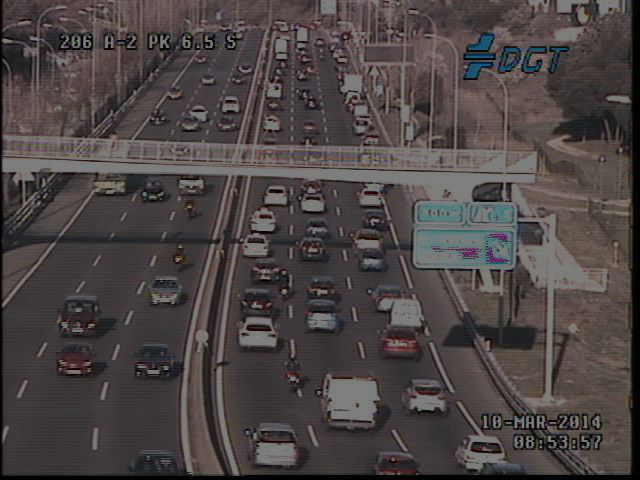

In [12]:
new_img = Image.blend(p, image, 0.5)
new_img

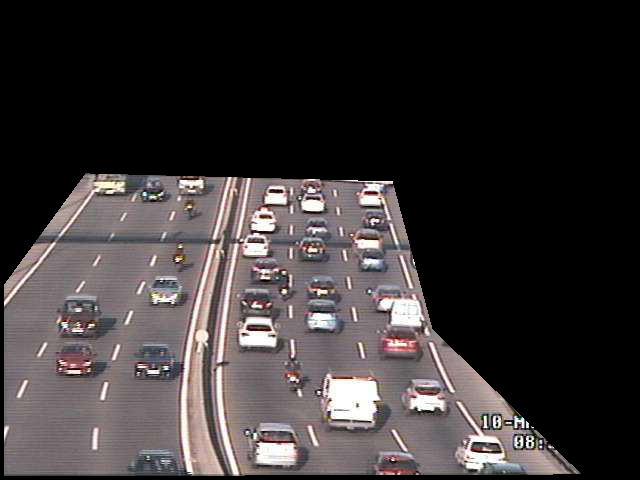

In [13]:
image = image * roi
points = hu.shrink2roi(points, roi).astype("uint8")
image, points = list(map(FT.to_pil_image, [image, points]))
image

In [14]:
points = points.resize([224, 224], Image.LANCZOS)

In [15]:
num_workers = 1
train_set = datasets.get_dataset(dataset_dict=exp_dict["dataset"],
                                     split="train",
                                     datadir=datadir,
                                     exp_dict=exp_dict,
                                     dataset_size=exp_dict['dataset_size'])
# val set
val_set = datasets.get_dataset(dataset_dict=exp_dict["dataset"],
                               split="val",
                               datadir=datadir,
                               exp_dict=exp_dict,
                               dataset_size=exp_dict['dataset_size'])

val_sampler = torch.utils.data.SequentialSampler(val_set)
val_loader = DataLoader(val_set,
                        sampler=val_sampler,
                        batch_size=1,
                        num_workers=num_workers)

In [16]:
model = models.get_model(model_dict=exp_dict['model'],
                             exp_dict=exp_dict,
                             train_set=train_set).cuda()
train_sampler = torch.utils.data.RandomSampler(
        train_set, replacement=True, num_samples=2*len(val_set))

train_loader = DataLoader(train_set,
                          sampler=train_sampler,
                          batch_size=exp_dict["batch_size"], 
                          drop_last=True, num_workers=num_workers)

In [17]:
s_epoch = 0
best_val = 100000
epochs_without_improvement = 0
for e in range(s_epoch, exp_dict['max_epoch']):
    # Validate only at the start of each cycle
    score_dict = {}

    # Train the model
    train_dict = model.train_on_loader(train_loader)

    # Validate and Visualize the model
    val_dict = model.val_on_loader(val_loader, 
                    savedir_images=os.path.join(savedir, "images"),
                    n_images=3)
    if(val_dict['val_mae'] < best_val):
        print('Better validation')
        best_val = val_dict['val_mae']   
        epochs_without_improvement = 0
    elif(epochs_without_improvement > 3):
        print('No improvement for 4 epochs')
        break
    else:
        epochs_without_improvement += 1
    score_dict.update(val_dict)
    # model.vis_on_loader(
    #     vis_loader, savedir=os.path.join(savedir, "images"))

    # Get new score_dict
    score_dict.update(train_dict)
    score_dict["epoch"] = len(score_list)

    # Add to score_list and save checkpoint
    score_list += [score_dict]

    # Report & Save
    score_df = pd.DataFrame(score_list)
    print("\n", score_df.tail(), "\n")
    hu.torch_save(model_path, model.get_state_dict())
    hu.save_pkl(score_list_path, score_list)
    print("Checkpoint Saved: %s" % savedir)

    # Save Best Checkpoint
    if e == 0 or (score_dict.get("val_score", 0) > score_df["val_score"][:-1].fillna(0).max()):
        hu.save_pkl(os.path.join(
            savedir, "score_list_best.pkl"), score_list)
        hu.torch_save(os.path.join(savedir, "model_best.pth"),
                      model.get_state_dict())
        print("Saved Best: %s" % savedir)

print('Experiment completed et epoch %d' % e)

  0%|          | 0/105 [00:00<?, ?it/s]/home/roberto/Documentos/PhD/LCFCN/src/datasets/transformers.py:47: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.LongTensor(np.asarray(x))
Training. Loss: 6.5076: 100%|██████████| 105/105 [01:54<00:00,  1.09s/it]


NameError: name 'savedir' is not defined

In [18]:
import cv2

error: OpenCV(4.5.1) /tmp/pip-req-build-jhawztrk/opencv/modules/highgui/src/window.cpp:634: error: (-2:Unspecified error) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Cocoa support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function 'cvNamedWindow'
